# get_pond_properties
Author: Connor Finn <br>
Date: July 29, 2020 <br>
Description: 
    This notebook will be used to determine the geometric properties of the salton sea. To accomplish this, I read in a number of pictures from my desired location, use the watermask method demonstrated by Arvind, and I used the area quantification method used by Prabhakar to calculate sqare kilometers. This [tutorial](https://developers.google.com/earth-engine/tutorial_forest_03) is also very useful.

In [1]:
import ee
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

# Trigger the authentication flow.
ee.Authenticate()

Enter verification code: 4/2gFT70t1WJmULJkL4YpPiklmY5y2KEpyr9eIx3fLtuiHOWXXFKUZOug

Successfully saved authorization token.


In [2]:
ee.Initialize()

# Prepare images of Salton Sea

## Part 1: Collect the images - all during the month of May (same as time lapse)
To do this, I use the same function we have been using, and added the month filter so that we can restrict it to just one month
### Define the Function

In [19]:
def get_images(path_list , row_list , satelite , start_date , end_date , max_cloud_percentage , months):
    
    # get image collection object
    coll = ee.ImageCollection(satelite)\
        .filterDate(start_date, end_date)\
        .filter(ee.Filter.inList('WRS_PATH', path_list))\
        .filter(ee.Filter.inList('WRS_ROW', row_list))\
        .filter(ee.Filter.lt('CLOUD_COVER' , max_cloud_percentage))\
        .filter(ee.Filter.calendarRange(months[0],months[1],'month'))    # just may data
    # get image_id's
    image_ids = list( map( lambda x : x['id'] , coll.getInfo()['features'] ) ) 
    
    # get image objects
    images = list( map( lambda x: ee.Image(x) , image_ids ) )
    
    return images


### Use the Function

In [147]:
# fill in the information
p = [39]                                    # path       
r = [37]                                    # row 
sat = 'LANDSAT/LC08/C01/T1_TOA'             # use this satelite
sd = '2013-05-01'                           # start date
ed = '2020-05-01'                           # end date
cc= 1                                       # max cloud cover percentage
months = [5 , 5]                            # months [start, end]
image_list = get_images(p, r, sat, sd, ed, cc , months)

## Part 2: Reduce the images to just the lake. 
For now I simply hard code a bounding box.<dir> This would be a fantastic place to impliment Prabhakar's algorithm which snaps to the nearest lake and builds a bounding box around it

In [148]:
lake_bounding_box = ([-116.21,33.58],\
 [-116.19,33.03],\
 [-115.36,33.04],\
 [-115.40,33.65])

lake_region = ee.Geometry.Rectangle([-116.21 , 33.03 , -115.36 , 33.65])

In [149]:
# this function clip to the lake
def clip(image):
    lake_region = ee.Geometry.Rectangle([-116.21 , 33.03 , -115.36 , 33.65])
    return image.clip(lake_region)

In [150]:
# map the function to our image_list
image_list = list(map(clip, image_list))

## Part 3: Mask the water. 
To quantify the lake, I need a band where water is 1, and land is 0.  I will do this with a watermask

In [151]:
# add ndwi and ndvi bands. For some reason, my NDWI is not working properly. (are they correct bands?)
def addNDWI(image):
    return image.addBands(image.normalizedDifference(['B5', 'B7']))


def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B3', 'B5']))

## Add NDVI, and display

In [152]:
image_list = list(map(addNDVI, image_list))        # set as 'nd'
parameters = {'min': -1.0, # value which is mapped to 0
              'max': 1.0,  # value which is mapped to 255
              'dimensions': 768,   # size of the image 
              'bands': ['nd'],     # The bands we select
              'palette': ['green', 'white', 'blue'],  # only use a pallete when visualizing one.
              #'region': lake_region
}

lake_image = image_list[0]
display(Image(url = lake_image.getThumbUrl(parameters)))

# Create a Water mask here
To follow with this [tutorial](https://developers.google.com/earth-engine/tutorial_forest_03), we need a band which gives a value equal to 1 for (in the lake), and 0 elsewise. <br>
I can see this expanding to a 1 for any location where land turns to water in future situations <dir>
    
    For now. This will be done using a water mask on the ndwi value. We will say use 0.01 as the cutoff value. Arvind provided the base code for creating the following watermask. I will then use the tutorial as well as some code provided to me by Prabhakar to calculate a numerical value for the water. 

## Part 1. May 2013

In [153]:
#Creating a water mask  based on the histogram shown earlier.
waterthreshold = .1;
image_ndvi = lake_image.select(['nd'])

watermask = image_ndvi.gte(waterthreshold) #creating a water mask. Any NDWI greater than waterthreshold value is taken to be water.

parameters = {'min': -0.5,
              'max': 0.4,
              'dimensions': 768,
              'palette': ['brown', 'white', 'blue'],
}
Image(url = watermask.getThumbUrl(parameters))

(array([810.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 169.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

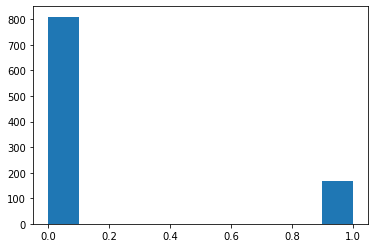

In [154]:
#What is in the watermask?
watermask_data = ee.List(watermask.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['nd']).get('list')).getInfo()
plt.hist(watermask_data) # You can see that the mask is a contrast - greater than threshold is categorized as 1 and the rest as 0.

### Compute area

To help compute areas, Earth Engine has the ee.Image.pixelArea() method which generates an image in which the value of each pixel is the pixel's area in square meters. Note that I am converting the javascript example to python here. The dictionary is now simply keywords.

In [155]:
'''
I calculate the sum of the water in the region.
Note that the pixel value is 1 where there is water and 0 where there is land. 
For this reason, a simple summation call will collect all the water pixels in the area. 
''' 
pixel_stats = watermask.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )

In [156]:
print( "The amount of pixels representing water in this image are, " , pixel_stats.getInfo()['nd'] )

The amount of pixels representing water in this image are,  1013983


### To convert to square meters. i use the ee.Image.pixelArea() method
This is a method Prabhakar used, and is also used in the tutorial

In [157]:
watermask_square_meter = watermask.multiply(ee.Image.pixelArea()).divide(1000*1000)

In [158]:
sqm_stats = watermask_square_meter.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )

In [159]:
print( "The amount of square kilometers representing water in this image are, " , sqm_stats.getInfo()['nd'] )

The amount of square kilometers representing water in this image are,  913.039838474064


## Part 2. May 2018
I recognize that this is a noisy estimate. However, I will use the last image and see if there has been any reduction.

In [160]:
last_lake_image = image_list[-1]

In [161]:
last_image_ndvi = last_lake_image.select(['nd'])
last_watermask = last_image_ndvi.gte(waterthreshold) #creating a water mask. Any NDWI greater than waterthreshold value is taken to be water.

parameters = {'min': -0.5,
              'max': 0.4,
              'dimensions': 768,
              'palette': ['brown', 'white', 'blue'],
}
Image(url = last_watermask.getThumbUrl(parameters))

In [162]:
last_watermask_square_kmeter = last_watermask.multiply(ee.Image.pixelArea()).divide(1000*1000)

last_pixel_stats = last_watermask.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )


last_sqm_stats = last_watermask_square_kmeter.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )
print( "The amount of pixels representing water in this image are, " , last_pixel_stats.getInfo()['nd'] )
print( "The amount of square kilometers representing water in this image are, " , last_sqm_stats.getInfo()['nd'] )

The amount of pixels representing water in this image are,  969300
The amount of square kilometers representing water in this image are,  872.8058068843354


# Chart the water area yearly

In [163]:
# Convert to imageCollection
image_collection = ee.ImageCollection.fromImages(image_list)


In [164]:
lake_image.getInfo().keys()

dict_keys(['type', 'bands', 'version', 'id', 'properties'])

In [165]:
year = int(lake_image.getInfo()['properties']['DATE_ACQUIRED'][:4])

In [166]:
def get_year(image):
    return int(image.getInfo()['properties']['DATE_ACQUIRED'][:4])

In [167]:
def get_date_string(image):
    return image.getInfo()['properties']['DATE_ACQUIRED']

In [168]:
# I am gonna leave this for now and use it if I need it
from datetime import date
now = date(*map(int, lake_image.getInfo()['properties']['DATE_ACQUIRED'].split('-')))

In [169]:
def get_km(image):
    thresh = 0.1
    image_ndvi = image.select(['nd'])
    watermask = image_ndvi.gte(thresh) #creating a water mask. Any NDWI greater than waterthreshold value is taken to be water.
    watermask_square_kmeter = watermask.multiply(ee.Image.pixelArea()).divide(1000*1000)
    return watermask_square_kmeter.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        ).getInfo()['nd']



In [170]:
dates = list(map(get_date_string, image_list))

In [171]:
years = list(map(get_year , image_list))

In [172]:
kms = list(map(get_km, image_list))

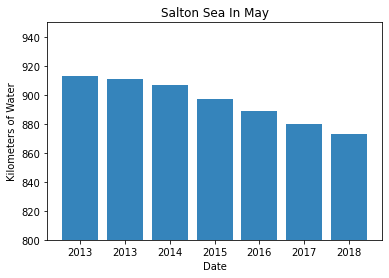

In [177]:

y_pos = list(range(len(dates)))


plt.bar(y_pos, kms, align='center', alpha=0.9)
plt.xticks(y_pos, years)
plt.ylim(800, 950)
plt.ylabel('Kilometers of Water')
plt.xlabel('Date')
plt.title('Salton Sea In May')

plt.show()